In [1]:
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

In [2]:
#dataset_name = 'synthetic'
dataset_name = 'MNIST'

In [3]:
class AE(tf.keras.Model):
    def __init__(self,original_dim, intermediate_dim,latent_dim,output_act):
        super(AE, self).__init__()
        self.dense1 = tf.keras.layers.Dense(intermediate_dim, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(latent_dim, activation=tf.nn.relu)
        self.dense3 = tf.keras.layers.Dense(intermediate_dim, activation=tf.nn.relu)
        self.dense4 = tf.keras.layers.Dense(original_dim,activation=output_act)

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)
        return x
    
    def get_latent(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        return x
    
    def get_sample(self,inputs):
        x = self.dense3(inputs)
        x = self.dense4(x)
        return x

In [4]:
if dataset_name == 'MNIST':
    (x_train, _), _ = tf.keras.datasets.mnist.load_data()
    x_train = x_train.reshape(60000, 784).astype('float32') / 255
elif dataset_name == 'synthetic':
    all_data= np.load('traj.npy').astype(np.float32)
    all_data= (all_data - all_data.mean())/all_data.std()
    np.random.shuffle(all_data)
    train_size = 100000
    x_train = all_data[:train_size]
    x_test = all_data[train_size:train_size*2]
    gm = GaussianMixture(n_components=8)
    clusters = gm.fit_predict(x_train)
    sns.distplot(x_train,label='train')
    sns.distplot(x_test,label='test')
    plt.legend()
else:
    raise Exception('Unknown Dataset')

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train,x_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(128)

In [6]:
if dataset_name == 'MNIST':
    original_dim=784
    intermediate_dim = 128
    model = AE(original_dim=original_dim, intermediate_dim=intermediate_dim, latent_dim=2,output_act="sigmoid")
    input_size = 28
    epoch_number = 4
else :
    original_dim=1
    intermediate_dim = 128
    model = AE(original_dim=original_dim, intermediate_dim=intermediate_dim, latent_dim=2,output_act=None)
    input_size = 1
    epoch_number = 4

In [7]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['MSE'])

In [8]:
model.fit(train_dataset, epochs=epoch_number)

Epoch 1/4
469/469 [==============================] - 2s 5ms/step - loss: 0.0787 - MSE: 0.0787
Epoch 2/4
469/469 [==============================] - 2s 5ms/step - loss: 0.0629 - MSE: 0.0629
Epoch 3/4
469/469 [==============================] - 3s 5ms/step - loss: 0.0570 - MSE: 0.0570
Epoch 4/4
469/469 [==============================] - 2s 5ms/step - loss: 0.0521 - MSE: 0.0521


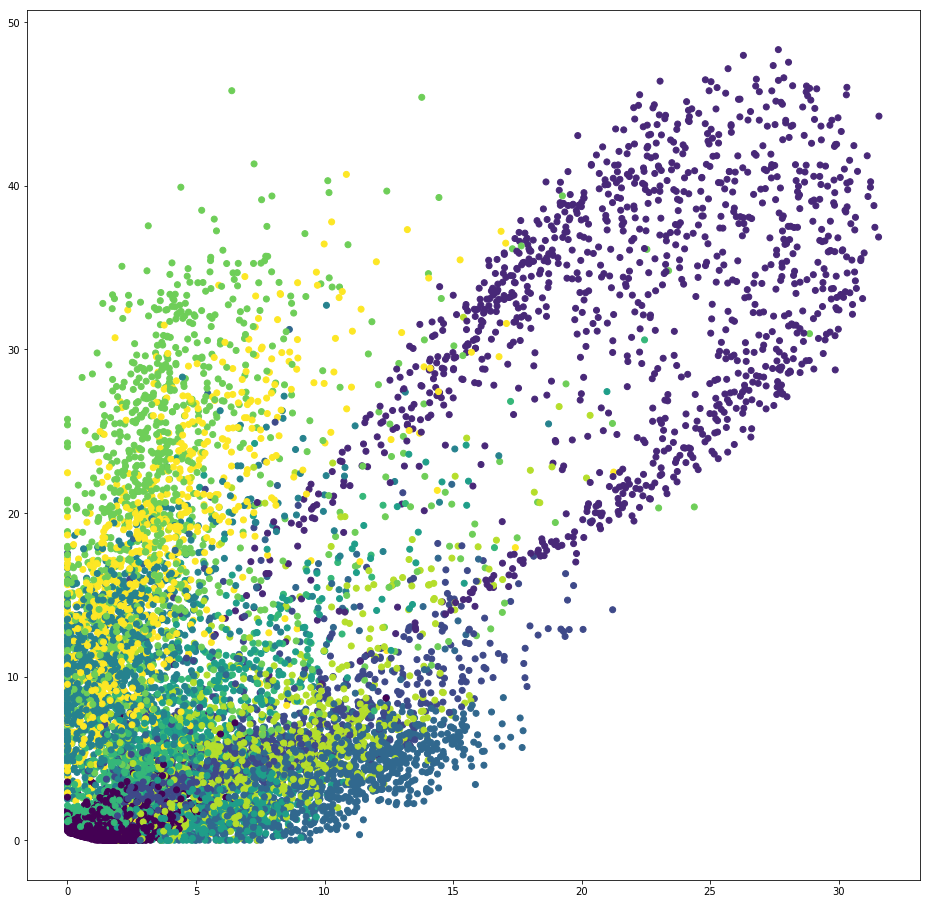

In [9]:
if dataset_name == "MNIST":
    (_, _), (x_test,label_test) = tf.keras.datasets.mnist.load_data()
    x_test = x_test.reshape(10000, 784).astype('float32') / 255
    latent = model.get_latent(x_test).numpy()
    plt.figure(figsize=(16,16))
    plt.scatter(latent[:,0],latent[:,1],c=label_test)
else:
    label_test = gm.predict(x_test)
    latent = model.get_latent(x_test).numpy()
    plt.figure(figsize=(16,16))
    plt.scatter(latent[:,0],latent[:,1],c=label_test)
plt.savefig('ae/ae_encoded_latent_' + dataset_name)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



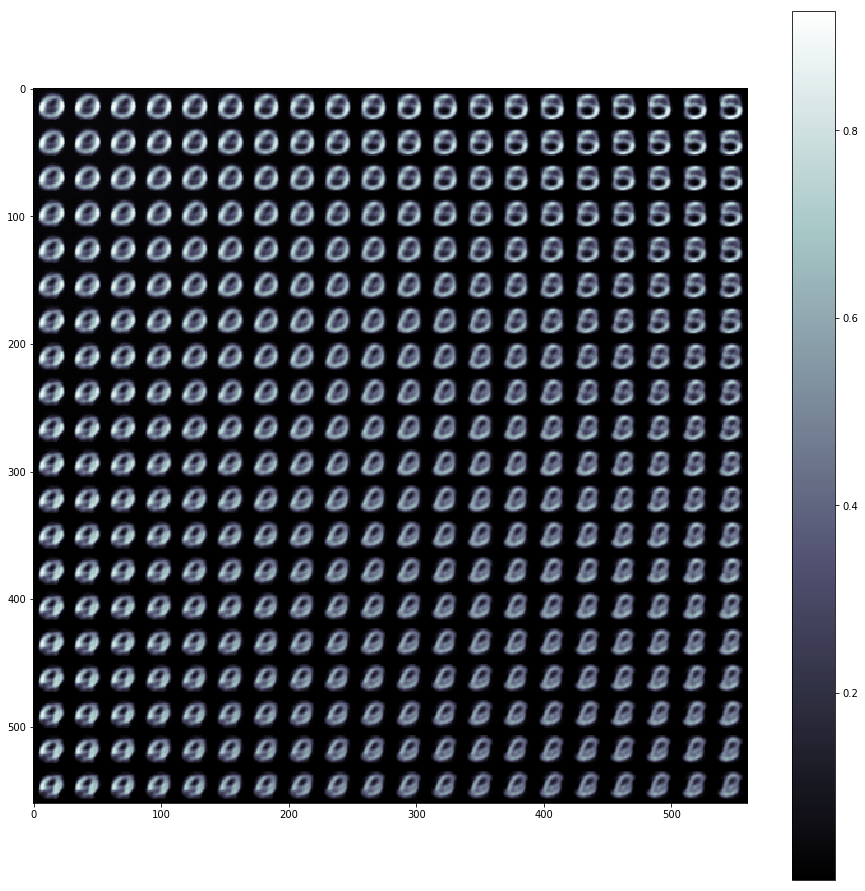

In [10]:
from scipy.stats import norm
batch_size = 1
n = 20
# figure with 20x20 digits
input_size = input_size
figure = np.zeros((input_size * n, input_size * n))
# Construct grid of latent variable values
grid_x = np.linspace(start=0,stop=4,num=n)
grid_y = np.linspace(start=0,stop=4,num=n)
# decode for each square in the grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = model.get_sample(z_sample)
        recon_sample = x_decoded[0].numpy().reshape(input_size, input_size)
        figure[i * input_size: (i + 1) * input_size,
               j * input_size: (j + 1) * input_size] = recon_sample

plt.figure(figsize=(16, 16))
#plt.matshow(figure, cmap='gnuplot2')
plt.imshow(figure, cmap='bone')
plt.colorbar()
plt.savefig('ae/ae_decoded_latent_' + dataset_name)
plt.show()  
